In [1]:
%matplotlib inline
#%pylab
import os
import matplotlib, commands
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
import scipy.stats
from scipy import interpolate
import pandas as pd
import itertools

In [2]:
# Define globals
### network name <=> data file mapping
_FILEMAP_={'vgg16a' : 'sp_vgg16a_iter_',
           'vgg16b' : 'sp_vgg16b_iter_',
           'vgg16c' : 'sp_vgg16c_iter_',
           'resnet14b'    : 'sp_resnet14b_iter_',
           'resnet14b_w4' : 'sp_resnet14b_w4_iter_',
           'resnet29b'    : 'sp_resnet29b_iter_',
           'resnet29b_w2' : 'sp_resnet29b_w2_iter_',
           'resnet29b_w4' : 'sp_resnet29b_w4_iter_',
           'resnet50b'    : 'sp_resnet50b_iter_',
           'plainresnet10b'    : 'sp_plainresnet10b_iter_',
           'plainresnet10b_w4' : 'sp_plainresnet10b_w4_iter_',
           'plainresnet12b'    : 'sp_plainresnet12b_iter_',
           'plainresnet18b'    : 'sp_plainresnet18b_iter_',
           'plainresnet18b_w4' : 'sp_plainresnet18b_w4_iter_',
           'plainresnet20b'    : 'sp_plainresnet20b_iter_',
           'plainresnet20b_w4' : 'sp_plainresnet20b_w4_iter_'
          }
_DATAMAP_={}
_FILEDIR_='testA'
_LABELS_=['eminus','gamma','muminus','piminus','proton']

In [3]:
def list_itr(netname):
    if not netname in _FILEMAP_:
        print 'Network not recognized:',netname
        return None
    f = _FILEDIR_ + '/' + _FILEMAP_[netname]
    itr_v = [int(f.rstrip('.csv').split('_')[-1]) for f in commands.getoutput('ls %s*csv' % f).split() if f.endswith('csv')]
    itr_v.sort()
    return itr_v

def get_df(netname,itr):
    key=(netname,itr)
    if key in _DATAMAP_:
        return _DATAMAP_[key]
    
    if not netname in _FILEMAP_:
        print 'Network not recognized:',netname
        return None
    
    itr_v = list_itr(netname)
    if not itr in itr_v:
        print 'Iteration',itr,'not found'
        return None

    f = _FILEDIR_ + '/' + _FILEMAP_[netname] + str(itr) + '.csv'
    if not os.path.isfile(f):
        print 'LOGIC ERROR ... file not found (should not happen):',f
        return None
    
    df = pd.read_csv(f)
    _DATAMAP_[key] = df
    return _DATAMAP_[key]


In [4]:
#
# Analysis: try printing accuracy per iteration
#

#
# Configurations
#
# network name
netname='resnet50b'

# Report network name
print 'Network',netname
print

# Report available list of iterations
itr_v = list_itr(netname)
print 'Iterations',itr_v
print

res={'all':[]}
for l in _LABELS_:
    res[l]=[]
    res['%s_ctr' % l]=[]

# Loop over iterations and print accuracy
for itr in itr_v:
    # Get data frame
    df = get_df(netname,itr)

    # Compute overall accuracy
    acc = len(df.query('label==prediction')) / float(len(df))
    acc = int(acc*10000)/100.
    res['all'].append(acc)
    
    # Compute per-particle accuracy
    for idx in xrange(len(_LABELS_)):
        label = _LABELS_[idx]
        total = float(len(df.query('label==%d' % idx)))
        res['%s_ctr' % label].append(total)
        
        if total<1.:
            res[label].append(0.)
        else:
            acc = len(df.query('label==prediction and label==%d' % idx)) / total
            acc = int(acc*10000)/100.
            res[label].append(acc)

res['Iteration'] = itr_v
res = pd.DataFrame(res)
print res

Network resnet50b

Iterations [314250, 314500, 314750, 315000, 315250, 315500, 315750]

   Iteration    all  eminus  eminus_ctr  gamma  gamma_ctr  muminus  \
0     314250  81.83   83.40        2500  79.84       2500    86.44   
1     314500  80.29   80.20        2500  85.84       2500    81.56   
2     314750  80.54   78.32        2500  85.08       2500    82.92   
3     315000  81.37   84.84        2500  79.76       2500    83.40   
4     315250  81.72   82.56        2500  80.44       2500    80.52   
5     315500  80.78   80.92        2500  83.16       2500    84.44   
6     315750  80.96   80.52        2500  84.72       2500    79.64   

   muminus_ctr  piminus  piminus_ctr  proton  proton_ctr  
0         2500    76.20         2500   83.28        2500  
1         2500    75.28         2500   78.60        2500  
2         2500    71.96         2500   84.44        2500  
3         2500    74.63         2500   84.24        2500  
4         2500    78.40         2500   86.72        2500

In [8]:
emin_v = [ res['eminus'][i] for i in xrange(res.shape[0])]
gam_v = [ res['gamma'][i] for i in xrange(res.shape[0])]
pi_v = [ res['piminus'][i] for i in xrange(res.shape[0])]
mu_v = [ res['muminus'][i] for i in xrange(res.shape[0])]
proton_v = [ res['proton'][i] for i in xrange(res.shape[0])]
all_v = [ res['all'][i] for i in xrange(res.shape[0])]

it_v =  [ res['Iteration'][i] for i in xrange(res.shape[0])]


print emin_v, gam_v

[83.400000000000006, 80.200000000000003, 78.319999999999993, 84.840000000000003, 82.560000000000002, 80.920000000000002, 80.519999999999996] [79.840000000000003, 85.840000000000003, 85.079999999999998, 79.760000000000005, 80.439999999999998, 83.159999999999997, 84.719999999999999]


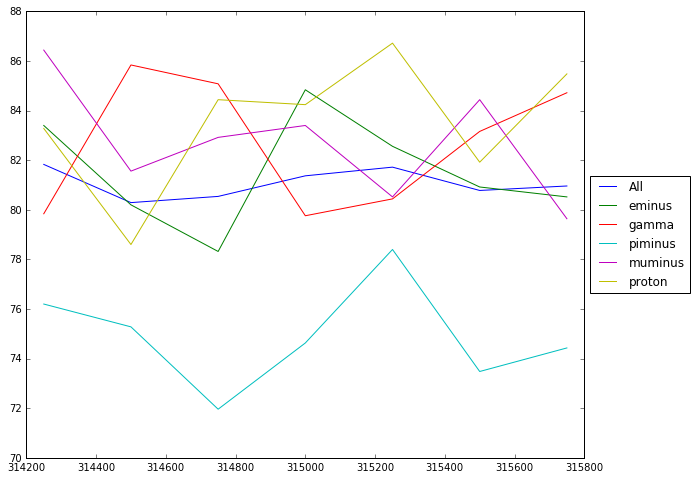

In [13]:
plt.figure(figsize=(10,8))
plt.plot(it_v,all_v,label='all')
plt.plot(it_v,emin_v,label='eminus')
plt.plot(it_v,gam_v,label='gamma')
plt.plot(it_v,pi_v,label='piminus')
plt.plot(it_v,mu_v,label='muminus')
plt.plot(it_v,proton_v,label='proton')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Iteration")
plt.ylabel("")